In [1]:
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, UpSampling2D
from keras.models import Sequential

%matplotlib inline

# RGB to grayscale (dimention reduction)
def convert_to_normalized_grayscale(array):

    a = np.zeros(shape=(array.shape[0], array.shape[1]))    
    
    #convert the image to grayscale and normalize the data
    for i in range(0, array.shape[0]):
        for j in range(0, array.shape[1]):
            a[i,j] = max(array[i,j,0], array[i,j,1], array[i,j,2]) / 255
    
    return a 

Using TensorFlow backend.


In [17]:
batchCounter = 1

batchSize = 600
dataSize = 4800
totalBatches = math.floor(dataSize / batchSize)

def load_next_batch():
    
    global batchCounter
    global training_input
    global testing_input
    global training_target
    global testing_target
    
    if batchCounter == totalBatches:
        batchCounter = 1

    batchStart = (batchSize * batchCounter) - batchSize + 1

    train_size = int(batchSize * 0.80);

    input_row_count = 72
    input_column_count = 72
    input_data = np.zeros((batchSize, input_row_count, input_column_count))

    for i in range(0, batchSize):
        newImg = np.array(Image.open("input/input_" + str(batchStart + i) + ".jpg"))
        newImg = convert_to_normalized_grayscale(newImg)
        input_data[i,:,:] = newImg

    training_input = input_data[0:train_size,:,:]
    testing_input = input_data[train_size:,:,:]

    target_row_count = 121 #121
    target_column_count = 180 #180
    target_data = np.zeros((batchSize, target_row_count, target_column_count))

    for i in range(0, batchSize):
        newImg = np.array(Image.open("target/target_" + str(batchStart + i) + ".jpg"))
        newImg = convert_to_normalized_grayscale(newImg)
        #crop
        #newImg = newImg[0:target_row_count, 0:target_column_count]
        target_data[i,:,:] = newImg

    #since tensorflow requires a 4D tesor as input, we put the values in in a fourth dimention.
    input_data = input_data.reshape(input_data.shape[0], input_row_count, input_column_count, 1)
    target_data = target_data.reshape(target_data.shape[0], target_row_count, target_column_count, 1)

    #splitting input data into training and validation
    training_input = input_data[0:train_size,:,:,:]
    testing_input = input_data[train_size:,:,:,:]

    #release the initial array from memory
    del input_data

    #splitting target data into training and validation
    training_target = target_data[0:train_size,:,:,:]
    testing_target = target_data[train_size:,:,:,:]

    del target_data
    
    batchCounter += 1

    print("done")

In [18]:
load_next_batch()

done


In [20]:
input_shape = (training_input.shape[1], training_input.shape[2], training_input.shape[3])
dropout = 0.4;

model1 = Sequential()
model1.add(Conv2D(12, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model1.add(Flatten())
model1.add(Dense(1176, activation='relu'))
model1.add(Dropout(dropout))
model1.add(Dense(1176, activation='relu'))
model1.add(Reshape((28, 42,1)))
model1.add(Conv2DTranspose(16, kernel_size=(5, 6), strides=(2, 2), activation='relu'))
model1.add(BatchNormalization(momentum=0.9))
model1.add(Conv2DTranspose(1, kernel_size=(5, 6), strides=(2, 2), activation='sigmoid')) 
model1.summary()

# For a mean squared error regression problem
model1.compile(optimizer='rmsprop',
              loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 34, 34, 12)        312       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 12)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 24)          7224      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1176)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1176)              1384152   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1176)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1176)              1384152   
__________

In [22]:
#tain with all batches
#for i in range(0, totalBatches * 1): # runs through the whole dataset x times
    
model1.fit(training_input, training_target, epochs=50, batch_size=batchSize)

score = model1.evaluate(testing_input, testing_target, batch_size=testing_target.shape[0])
    
    #load_next_batch()

Epoch 1/50
480/480 [==============================] - 1s - loss: 0.2124
Epoch 2/50
480/480 [==============================] - 1s - loss: 0.2062
Epoch 3/50
480/480 [==============================] - 1s - loss: 0.2010
Epoch 4/50
480/480 [==============================] - 1s - loss: 0.1948
Epoch 5/50
480/480 [==============================] - 1s - loss: 0.1863
Epoch 6/50
480/480 [==============================] - 1s - loss: 0.1850
Epoch 7/50
480/480 [==============================] - 1s - loss: 0.1902
Epoch 8/50
480/480 [==============================] - 1s - loss: 0.1790
Epoch 9/50
480/480 [==============================] - 1s - loss: 0.1938
Epoch 10/50
480/480 [==============================] - 1s - loss: 0.1698
Epoch 11/50
480/480 [==============================] - 1s - loss: 0.1624
Epoch 12/50
480/480 [==============================] - 1s - loss: 0.1563
Epoch 13/50
480/480 [==============================] - 1s - loss: 0.1574
Epoch 14/50
480/480 [==============================] - 1s - 

In [23]:
score

0.1382620632648468

In [29]:
#Load the test data generated on a sperate 3D model than the one used in the trainin

test_size = 100
input_row_count = 72
input_column_count = 72
input_test_data = np.zeros((test_size, input_row_count, input_column_count))

for i in range(0, test_size):
    newImg = np.array(Image.open("final_test/input/input_" + str(1 + i) + ".jpg"))
    newImg = convert_to_normalized_grayscale(newImg)
    input_test_data[i,:,:] = newImg


target_row_count = 121 #121
target_column_count = 180 #180
target_test_data = np.zeros((test_size, target_row_count, target_column_count))

for i in range(0, test_size):
    newImg = np.array(Image.open("final_test/target/target_" + str(1 + i) + ".jpg"))
    newImg = convert_to_normalized_grayscale(newImg)
    target_test_data[i,:,:] = newImg

#since tensorflow requires a 4D tesor as input, we put the values in in a fourth dimention.
input_test_data = input_test_data.reshape(input_test_data.shape[0], input_row_count, input_column_count, 1)
target_test_data = target_test_data.reshape(target_test_data.shape[0], target_row_count, target_column_count, 1)

final_test_score = model1.evaluate(input_test_data, target_test_data, batch_size=target_test_data.shape[0])
final_test_score

100/100 [==============================] - 0s


0.13659048080444336

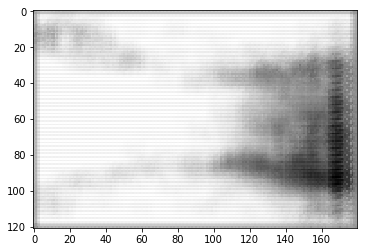

In [30]:
generated = model1.predict(input_test_data[0:test_size,:,:,:])
plt.imshow(generated[45,:,:,0], cmap='gray', interpolation='nearest')

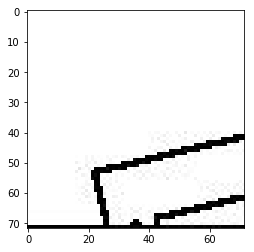

In [36]:
plt.imshow(input_test_data[45,:,:,0], cmap='gray', interpolation='nearest')

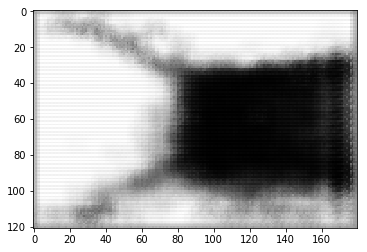

In [35]:
plt.imshow(generated[19,:,:,0], cmap='gray', interpolation='nearest')

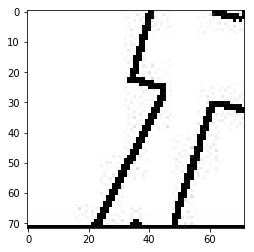

In [34]:
plt.imshow(input_test_data[19,:,:,0], cmap='gray', interpolation='nearest')

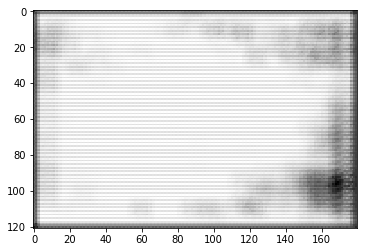

In [33]:
plt.imshow(generated[30,:,:,0], cmap='gray', interpolation='nearest')

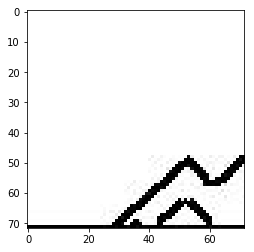

In [32]:
plt.imshow(input_test_data[30,:,:,0], cmap='gray', interpolation='nearest')